<a href="https://colab.research.google.com/github/sujithjp/Mini-Project/blob/main/InceptionV3%20Facial%20Skin%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import keras
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import (
    Input, Conv2D,
    Flatten, Dense, Dropout, AveragePooling2D
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import MaxPool2D , concatenate , GlobalAveragePooling2D , Dense , Dropout
from tensorflow.keras import models, layers
from IPython.display import HTML
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/NEW DATA'

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE =[299,299]
CHANNELS=3
EPOCHS=100

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception.layers:
  print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/NEW DATA",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 625 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 299, 299, 3)
[0 1 1 4 1 3 4 1 4 0 4 4 2 4 1 2 4 0 3 2 3 1 1 0 1 1 2 2 4 0 3 3]


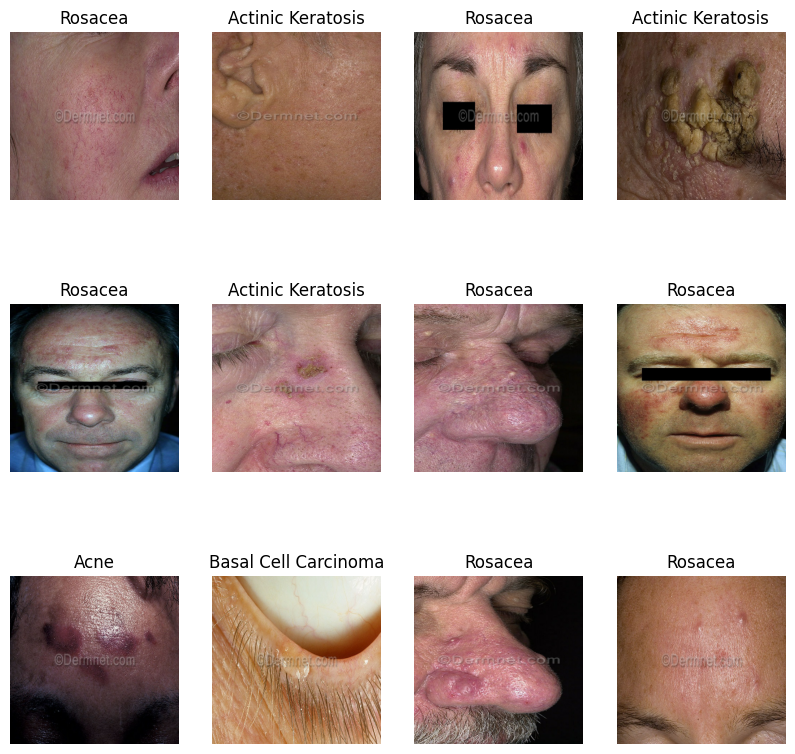

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

20

In [ ]:
train_size = 0.8
len(dataset)*train_size

16.0

In [ ]:
train_ds = dataset.take(12)
len(train_ds)

12

In [ ]:
test_ds = dataset.skip(12)
len(test_ds)

8

In [ ]:
val_size=0.1
len(dataset)*val_size

2.0

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

7

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
def resize_and_rescale(images):

  images = tf.image.resize(images, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
  images = images / 255.0

  return images

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
  layers.Rescaling(1./255)
])

In [ ]:
inception.trainable = True

set_trainable = False

for layer in inception.layers:
  if layer.name == 'conv2d':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in inception.layers:
  print(layer.name,layer.trainable)

input_1 False
conv2d True
batch_normalization True
activation True
conv2d_1 True
batch_normalization_1 True
activation_1 True
conv2d_2 True
batch_normalization_2 True
activation_2 True
max_pooling2d True
conv2d_3 True
batch_normalization_3 True
activation_3 True
conv2d_4 True
batch_normalization_4 True
activation_4 True
max_pooling2d_1 True
conv2d_8 True
batch_normalization_8 True
activation_8 True
conv2d_6 True
conv2d_9 True
batch_normalization_6 True
batch_normalization_9 True
activation_6 True
activation_9 True
average_pooling2d True
conv2d_5 True
conv2d_7 True
conv2d_10 True
conv2d_11 True
batch_normalization_5 True
batch_normalization_7 True
batch_normalization_10 True
batch_normalization_11 True
activation_5 True
activation_7 True
activation_10 True
activation_11 True
mixed0 True
conv2d_15 True
batch_normalization_15 True
activation_15 True
conv2d_13 True
conv2d_16 True
batch_normalization_13 True
batch_normalization_16 True
activation_13 True
activation_16 True
average_pooling2d

In [ ]:
folders = glob('//content/drive/MyDrive/NEW DATA*')
folders

['//content/drive/MyDrive/NEW DATA']

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs= inception.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
16/16 [==============================] - 79s 620ms/step - loss: 63.7933 - accuracy: 0.2535 - val_loss: 23.6536 - val_accuracy: 0.2656
Epoch 2/100
16/16 [==============================] - 2s 132ms/step - loss: 11.8221 - accuracy: 0.4487 - val_loss: 4.7749 - val_accuracy: 0.5156
Epoch 3/100
16/16 [==============================] - 2s 139ms/step - loss: 4.7168 - accuracy: 0.4930 - val_loss: 4.8532 - val_accuracy: 0.4062
Epoch 4/100
16/16 [==============================] - 2s 130ms/step - loss: 2.6444 - accuracy: 0.5714 - val_loss: 2.5046 - val_accuracy: 0.4531
Epoch 5/100
16/16 [==============================] - 2s 131ms/step - loss: 1.9321 - accuracy: 0.5755 - val_loss: 1.6777 - val_accuracy: 0.5625
Epoch 6/100
16/16 [==============================] - 2s 145ms/step - loss: 1.6803 - accuracy: 0.5976 - val_loss: 2.5652 - val_accuracy: 0.5312
Epoch 7/100
16/16 [==============================] - 2s 145ms/step - loss: 1.7118 - accuracy: 0.5976 - val_loss: 1.6434 - val_accuracy: 0.

In [ ]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 4s 149ms/step - loss: 0.2867 - accuracy: 0.9184


In [ ]:
scores

[0.2867361307144165, 0.918367326259613]

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 16}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

100

In [ ]:
history.history['loss'][:5]

[63.7933349609375,
 11.82211971282959,
 4.716832637786865,
 2.64436674118042,
 1.9321496486663818]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs=100

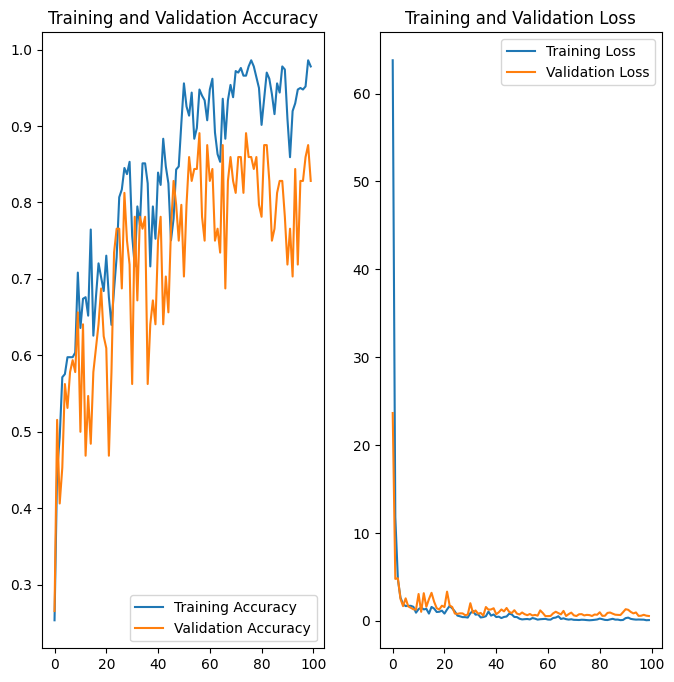

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image to predict
actual label: Acne
1/1 [==============================] - 1s 1s/step
predicted label: Acne


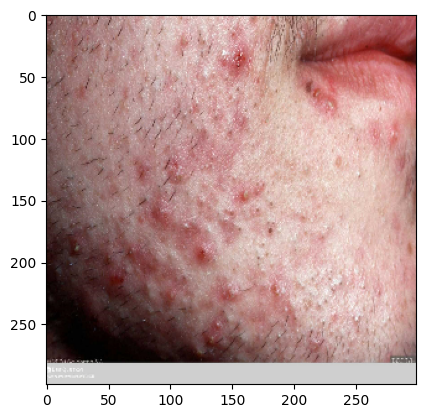

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()

    print("Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[first_label])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[first_label]
    confidence = round(100 * (first_label), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


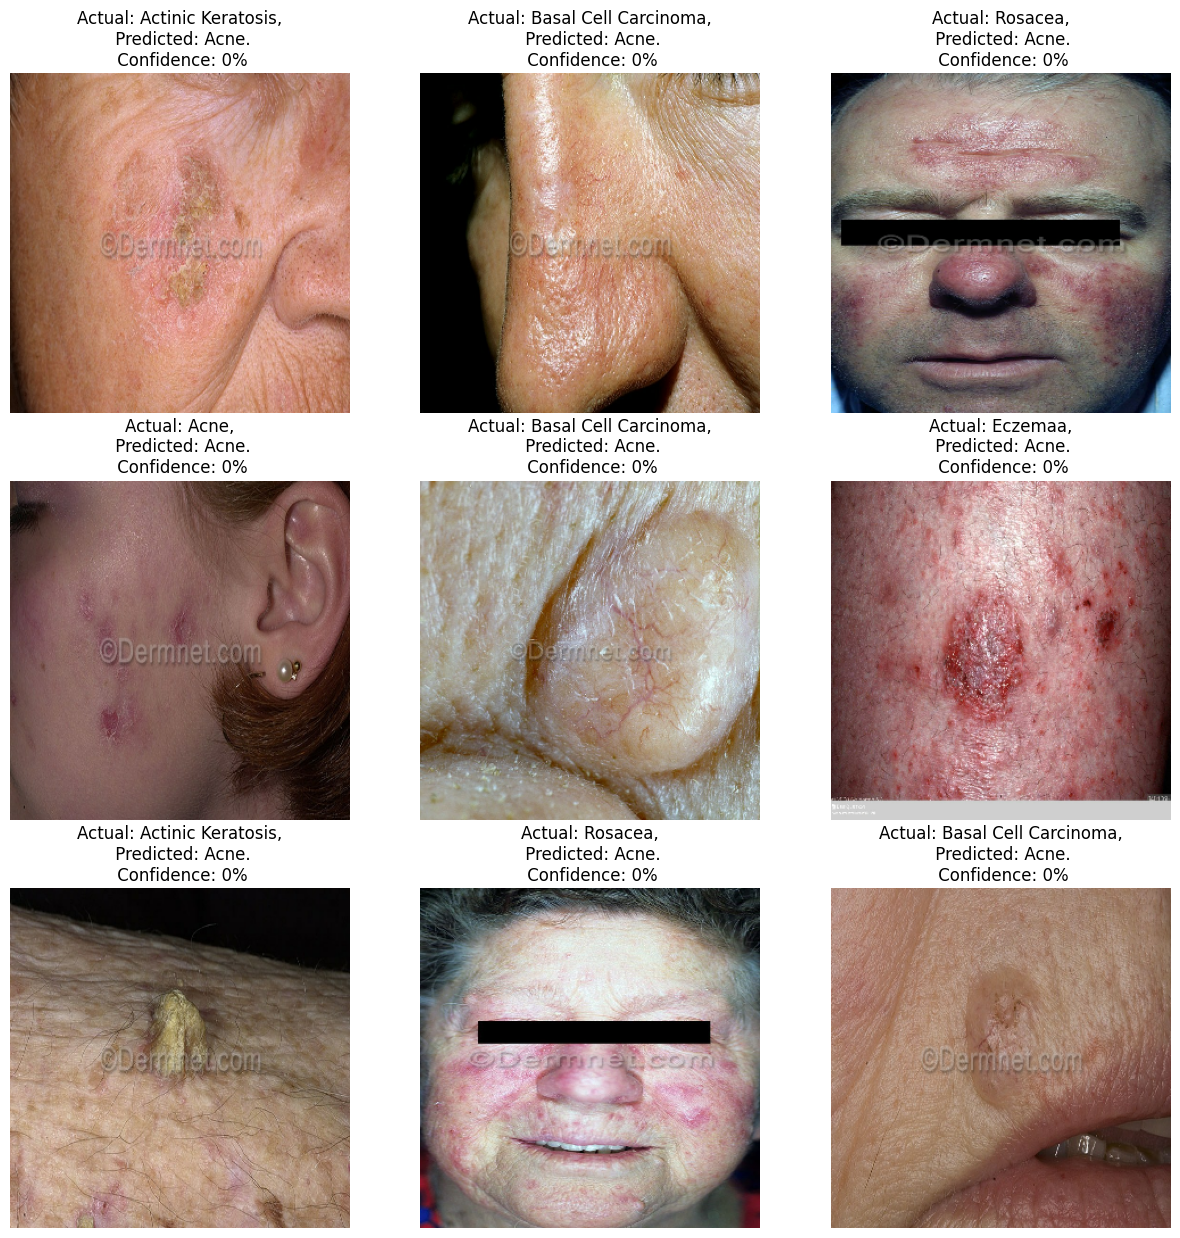

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 2s 194ms/step


In [ ]:
model.save('/content/drive/MyDrive/NEW DATA/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
Skin = load_model('/content/drive/MyDrive/NEW DATA/my_model.h5')

In [ ]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to the size your model expects
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if your model was trained on normalized images
    return img_array
img_path = '/content/download.jpg'
img_array = load_and_preprocess_image(img_path)

# Step 3: Make a Prediction
predictions = Skin.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability class

# Step 4: Interpret the Prediction
predicted_class_name = class_names[predicted_class]

1/1 [==============================] - 3s 3s/step


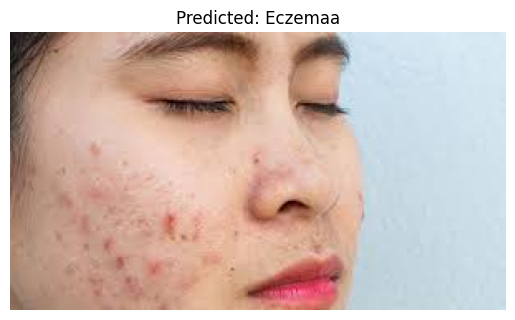

In [ ]:
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()